In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mrmr import mrmr_classif

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import precision_recall_curve, auc, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

In [54]:
train_df = pd.read_csv('obs_train.csv')
test_df = pd.read_csv('obs_test.csv')

y = train_df['SepsisLabel']
X = train_df.drop(columns=['SepsisLabel', 'person_id', 'datetime'])
K = 100

selected_features = mrmr_classif(X=X, y=y, K = K)

100%|██████████| 100/100 [05:26<00:00,  3.26s/it]


(colsample_bytree = 0.80,
            gamma = 0.7,
            learning_rate = 0.01,
            max_depth = 5,
            min_child_weight = 20,
            n_estimators = 100,
            reg_alpha = .9,
            reg_lambda = .9,
            subsample = 0.50,
            objective='binary:logistic',
            eval_metric='aucpr',
            random_state=42,)

In [55]:
for x in selected_features:
    print(x)

epinephrine
datetime_day
dopamine
procedure_Dialysis procedure
dobutamine
norepinephrine
epinephrine.1
milrinone
epinephrine.2
dopamine.1
intravenous
norepinephrine.1
 arterial blood pressure catheter
milrinone.1
procedure_Invasive ventilation
intravenous.1
Glasgow coma scale
dobutamine.1
milrinone.2
levosimendan
ertapenem.2
Right pupil Pupillary response_Sluggish
dopamine.2
norepinephrine.2
Left pupil Pupillary response_Sluggish
intravenous.2
erythromycin.2
procedure_Peritoneal dialysis
Neutrophil Ab [Units/volume] in Serum
procedure_Extracorporeal membrane oxygenation
Right pupil Diameter Auto
hours_since_admit
dobutamine.2
levosimendan.1
C reactive protein [Mass/volume] in Serum or Plasma
procedure_Non-invasive ventilation
Left pupil Diameter Auto
dexamethasone.2
Sodium [Moles/volume] in Serum or Plasma
Arterial pulse pressure_Absent
oral.1
levosimendan.2
Left pupil Pupillary response_Unresponsive
anidulafungin
dexamethasone.1
time_since_last_procedure
amoxicillin
Quirúrgico - Elect

In [56]:
def train_model(training_df):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
    
    training_aucs = []
    testing_aucs = []
    
    for train_idx, test_idx in sgkf.split(training_df, training_df['SepsisLabel'], groups=training_df['person_id']):
        train_df = training_df.iloc[train_idx].copy()
        test_df = training_df.iloc[test_idx].copy()
    
        train_df.drop(columns=['person_id', 'datetime'], inplace=True)
        test_df.drop(columns=['person_id', 'datetime'], inplace=True)
    
        train_y = train_df['SepsisLabel']
        train_X = train_df.drop(columns='SepsisLabel')
        test_y = test_df['SepsisLabel']
        test_X = test_df.drop(columns='SepsisLabel')
    
        mmx = MinMaxScaler()
        train_X = mmx.fit_transform(train_X)
        test_X = mmx.transform(test_X)
    
        clf = XGBClassifier(
            colsample_bytree = 0.80,
            gamma = 0.7,
            learning_rate = 0.01,
            max_depth = 5,
            min_child_weight = 20,
            n_estimators = 100,
            reg_alpha = .9,
            reg_lambda = .9,
            subsample = 0.50,
            objective='binary:logistic',
            eval_metric='aucpr',
            random_state=42,
        )
    
        clf.fit(train_X, train_y)
    
        test_proba_y = clf.predict_proba(test_X)[:, 1]
        train_proba_y = clf.predict_proba(train_X)[:, 1]

        test_prec, test_recall, _ = precision_recall_curve(test_y, test_proba_y)
        test_auc = auc(test_recall, test_prec)

        train_prec, train_recall, _ = precision_recall_curve(train_y, train_proba_y)
        train_auc = auc(train_recall, train_prec)

        testing_aucs.append(test_auc)
        training_aucs.append(train_auc)

    return training_aucs, testing_aucs

In [57]:
train_aucs_cols, test_aucs_cols = [], []
for num_columns in range(1, K + 1):
    cols = selected_features[:num_columns]
    mrmr_train = train_df[['person_id', 'datetime', 'SepsisLabel'] + cols]
    training_aucs, testing_aucs = train_model(mrmr_train) 
    print(f'Num cols:{num_columns}, Train Auc: {np.mean(training_aucs):.3f}, Test Auc: {np.mean(testing_aucs):.3f}')
    train_aucs_cols.append(np.mean(training_aucs))
    test_aucs_cols.append(np.mean(testing_aucs))

Num cols:1, Train Auc: 0.482, Test Auc: 0.351
Num cols:2, Train Auc: 0.458, Test Auc: 0.348
Num cols:3, Train Auc: 0.541, Test Auc: 0.405
Num cols:4, Train Auc: 0.571, Test Auc: 0.438
Num cols:5, Train Auc: 0.588, Test Auc: 0.447
Num cols:6, Train Auc: 0.611, Test Auc: 0.414
Num cols:7, Train Auc: 0.617, Test Auc: 0.443
Num cols:8, Train Auc: 0.622, Test Auc: 0.465
Num cols:9, Train Auc: 0.640, Test Auc: 0.460
Num cols:10, Train Auc: 0.645, Test Auc: 0.459
Num cols:11, Train Auc: 0.647, Test Auc: 0.459
Num cols:12, Train Auc: 0.648, Test Auc: 0.462
Num cols:13, Train Auc: 0.676, Test Auc: 0.443
Num cols:14, Train Auc: 0.679, Test Auc: 0.443
Num cols:15, Train Auc: 0.686, Test Auc: 0.418
Num cols:16, Train Auc: 0.689, Test Auc: 0.419
Num cols:17, Train Auc: 0.689, Test Auc: 0.414
Num cols:18, Train Auc: 0.692, Test Auc: 0.414
Num cols:19, Train Auc: 0.703, Test Auc: 0.420
Num cols:20, Train Auc: 0.709, Test Auc: 0.429
Num cols:21, Train Auc: 0.710, Test Auc: 0.422
Num cols:22, Train Auc

KeyboardInterrupt: 

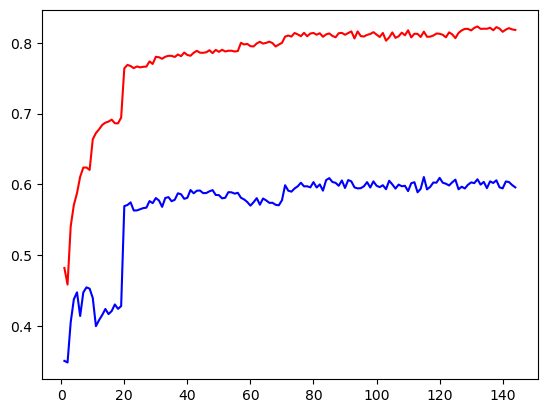

In [ ]:
plt.plot(range(1, 101), train_aucs_cols,'r')
plt.plot(range(1, 101), test_aucs_cols, 'b')
plt.show()

In [51]:
# mrmr_train = train_df[['person_id', 'datetime', 'SepsisLabel'] + selected_features[:86]]
# mrmr_test = test_df[['person_id', 'datetime'] + selected_features[:86]]

In [52]:
# mrmr_train.to_csv('mrmr_train.csv', index=False)
# mrmr_test.to_csv('mrmr_test.csv', index = False)